In [5]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision import transforms
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = 'cuda' if use_cuda else 'cpu'

True


In [7]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

2023-03-06 09:18:29.183069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 09:18:29.184110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/milla/.local/lib/python3.10/site-packages/cv2/../../lib64::/home/milla/miniforge3/lib/
2023-03-06 09:18:29.223101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/milla/.local/lib/python3.10/site-packages/cv2/../../lib64::/home/milla/miniforge3/lib/
2023-03-06 09:18:29.223281: W tensorflow/core/common_runtime/gpu/

In [26]:
# USE_ENET2=False
# NUM_EMOTIONS=7 #7 #
# if NUM_EMOTIONS==7:
#     idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
#     # idx_to_class={0: 'neg', 1: 'neg', 2: 'neg', 3: 'pos', 4: 'pos', 5: 'neg', 6: 'pos'}
# else:
#     idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
# if USE_ENET2:
#     IMG_SIZE=260
#     if NUM_EMOTIONS==7: # 7 emotions
#         PATH='../models/affectnet_emotions/enet_b2_7.pt'
#     else:
#         PATH='../models/affectnet_emotions/enet_b2_8.pt'
# else:
#     IMG_SIZE=224
#     if NUM_EMOTIONS==7: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
#         PATH='../models/affectnet_emotions/enet_b0_7.pt'
#     else:
#         #PATH='../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
#         PATH='/home/milla/test_emotions/models/affectnet_emotions/enet_b0_8_best_afew.pt'

In [32]:
IMG_SIZE=224
PATH='../models/affectnet_emotions/enet_b0_7.pt'
# idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
idx_to_class={0: 'neg', 1: 'neg', 2: 'neg', 3: 'pos', 4: 'pos', 5: 'neg', 6: 'pos'}
imagespath = '/home/milla/emotional_recognition/test/'


In [9]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [10]:
def loadmodel(path):
    model = torch.load(path,map_location=torch.device('cpu'))
    model=model.to(device)
    model.eval()
    return model
model= loadmodel(PATH)

In [25]:
def find_emotion(fpath, model):
    frame_bgr=cv2.imread(fpath)
    plt.figure(figsize=(5, 5))
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(frame)
    bounding_boxes, points = imgProcessing.detect_faces(frame)
    points = points.T
    emo_per_box = []
    emo_name = []
    for bbox,p in zip(bounding_boxes, points):
        # print(bbox)
        # print(p)
        box = bbox.astype(int)
        x1,y1,x2,y2=box[0:4]    
        face_img=frame[y1:y2,x1:x2,:]
        
        img_tensor = test_transforms(Image.fromarray(face_img))
        img_tensor.unsqueeze_(0)
        
        scores = model(img_tensor.to(device))
        scores=scores[0].data.cpu().numpy()
        if max(scores) < 4.0:
            emotions_name = idx_to_class[4]
        else:
            emotions_name = idx_to_class[np.argmax(scores)]
        # plt.figure(figsize=(3, 3))
        # plt.axis('off')
        # plt.imshow(face_img)
        # emotions = scores
        # emotions_name = idx_to_class[np.argmax(scores)]
        # plt.title(emotions_name)
        # emo_per_box.append(emotions)
        emo_name.append(emotions_name)
    # print(emo_name.count('neg'))
    # print(len(emo_name))
    if emo_name.count('neg')>0 and len(emo_name)<=3:
        pass
    else:
        return fpath


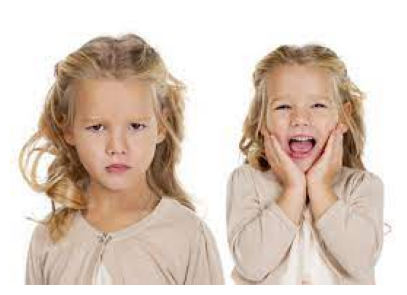

In [18]:
fpath='/home/milla/emotional_recognition/test/sad_happy2.jpeg'
find_emotion(fpath,model)


'/home/milla/emotional_recognition/test/PHOTO-2023-02-17-15-56-09(1).jpg'

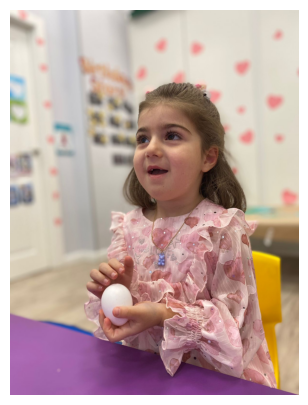

In [26]:
fpath2 = '/home/milla/emotional_recognition/test/PHOTO-2023-02-17-15-56-09(1).jpg'
find_emotion(fpath2, model)

In [30]:
def emo_search(imagespath):
    caught = []
    for fpath in os.listdir(imagespath)[11:13]:
        f1 = imagespath+ fpath 
        a = find_emotion(f1,model)
        if (a != None):
            # print(a)
            caught.append(a)
    return caught

['/home/milla/emotional_recognition/test/PHOTO-2023-02-28-17-19-04.jpg',
 '/home/milla/emotional_recognition/test/PHOTO-2023-03-01-17-03-43(1).jpg']

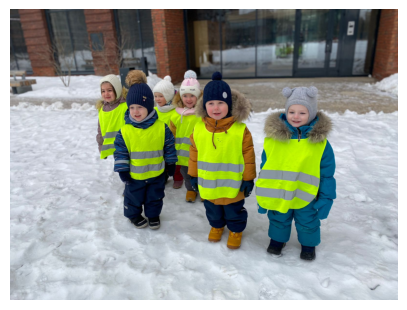

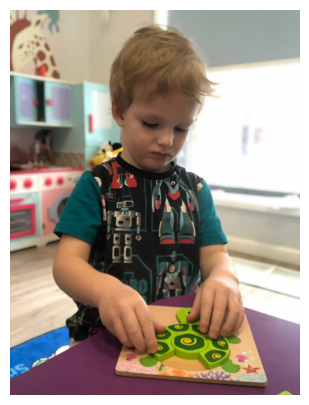

In [33]:
emo_search(imagespath)

In [11]:
def main():
    IMG_SIZE=224
    PATH='../models/affectnet_emotions/enet_b0_7.pt'

    # idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
    idx_to_class={0: 'neg', 1: 'neg', 2: 'neg', 3: 'pos', 4: 'pos', 5: 'neg', 6: 'pos'}

    test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
    imagespath = '/home/milla/emotional_recognition/test/'
    imageslist = emo_search(imagespath)
    return imageslist
    


    